In [0]:
! pip3 install torch torchvision
# workaround for google colab
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.image

## Transfer Learning

Practically difficult to train an entire Convolutional Neural Network (CNN ) from scratch ( with random initialization) , as it is difficult to have a dataset of sufficient size. Instead it is common to pretrain a CNN on a large dataset ( Imagenet ) and then use use the CNN either as an initialization or a fixed feature extractor for the task of interest. The major transfer learning scenarios can be :

* **Finetuning a ConvNet ** Instead of random initaliziation , we initialize the network with a pretrained network (eg trained on Imagenet) 
* ** CNN as fixed feature extractor ** Freezing the weights for all the network except for the final fully connected layer . The final layer is replaced with a new one with random weights and only this layer is trained .

In [0]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torchvision
from torchvision import datasets,models,transforms

import matplotlib.pyplot as plt
import os
plt.ion()

### Loading data 

Using **torchvision and torch.utils.data** for loading data

Problem -Train a model to classify **ants** and **bees** 

Data - 120 training images each for bees and ants . 75 images in validation set

Since the dataset is pretty small, it is difficult to generalize. Thus can use transfer learning here 

Url - https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [0]:
# Uncomment to download and unzip the files 

# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip

### Data Augmentations and Normalizations

In [0]:
# Training set - Data Augmentation + Normalization
# Validation set - Normalization

data_transforms = {
    # transforms.Compose - Mix several transformations together 
    'train':transforms.Compose([
        # transform of random size , here O/P =224
        transforms.RandomResizedCrop(224),
        # flip the image horizontally with a probability - 0.5 default
        transforms.RandomHorizontalFlip(),
        # Convert the image to torch.FloatTensor of shape - (Channel x Height x Width)
        transforms.ToTensor(),
        # Normalize the image with mean and std - values for imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
    # transformations for validatio set 
    'val':transforms.Compose([
        # Resize image
        transforms.Resize(256),
        # Crop the image at center
        transforms.CenterCrop(224),
        # Convert the image to torch.FloatTensor of shape - (Channel x Height x Width)
        transforms.ToTensor(),
        # Normalize the image with mean and std - values for imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Data directory
data_dir ='hymenoptera_data'

# setting the image datasets and applying transformations
image_datasets ={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) 
                  for x in ['train','val']}

# creating a dataloader - combine dataset and sampler and provide single or multi process iterator over dataset
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],
                       batch_size=4,shuffle=True,num_workers=4) 
               for x in ['train','val']}

# dataset size 
dataset_size = {x:len(image_datasets[x]) for x in ['train','val']}

# class name
class_names = image_datasets['train'].classes

device = torch.device("cuda:0")

In [7]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root Location: hymenoptera_data/train
     Transforms (if any): Compose(
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root Location: hymenoptera_data/val
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms 

In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd340a03048>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fd340a308d0>}

In [9]:
dataset_size

{'train': 244, 'val': 153}

In [10]:
class_names

['ants', 'bees']

### Visualizing the data

tensor([0, 1, 0, 1])


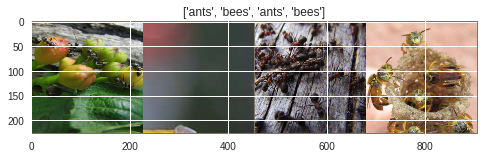

In [11]:
def imgshow(inp , title=None):
  """Imgshow for tensors"""
  inp = inp.numpy().transpose((1,2,0))  
  mean = np.array([[0.485, 0.456, 0.406]])
  std = np.array([[0.229, 0.224, 0.225]])
  inp = std * inp + mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  # pause to finish update to plot
  plt.pause(0.001)

# Grab a bunch of training data
inputs,classes = next(iter(dataloaders['train']))

print(classes)

# Making a grid of images from batch
out = torchvision.utils.make_grid(inputs)

imgshow(out,title=[class_names[x] for x in classes])


### Training the model

* scheduling the learning rate
* saving the best model

Using learning rate scheduler from ** torch.optim.lr_scheduler **

In [0]:
from torch.optim import lr_scheduler
import copy
import time

In [0]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
  since = time.time()
  
  best_model_weights = copy.deepcopy(model.state_dict())
  best_accuracy = 0.0
  
  for epoch in range(num_epochs):
    
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
 
    # Each epoch has a training and a validation phase
    for phase in ['train','val']:
      if phase == 'train':
        scheduler.step()
        # set model to training mode
        model.train()
      else:
        # set model to evaluation mode
        model.eval()        
      running_loss = 0.0
      running_corrects = 0.0      
      # Iterate over data
      for inputs,labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)        
        # Zero the gradients
        optimizer.zero_grad()        
        # Forward pass , track history only in train
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)
          loss = criterion(outputs,labels)          
          # backward pass in case of train
          if phase=='train':
            loss.backward()
            optimizer.step()        
        # stats calculation
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
      epoch_loss = running_loss/dataset_size[phase]
      epoch_acc = running_corrects.double() / dataset_size[phase]
      
      print(f'{epoch} - {phase} Loss: {epoch_loss} Acc:{epoch_acc}')
      
      # Copy the model 
      if epoch_acc > best_accuracy:
        best_accuracy = epoch_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        
  print()
    
  time_elapsed = time.time() - since
  print( f'Training Completed in {time_elapsed // 60}m : {time_elapsed %60}s')
  print(f'Best Accuracy: {best_accuracy}')
 
  model.load_state_dict(best_model_weights)
  return model
  
  

### Visualizing the model predictions 

In [0]:
# Generic function to display predictions 
def visualize_model(model,num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  
  with torch.no_grad():
    for i , (inputs,labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _,preds = torch.max(outputs,1)
      
      for j in range(inputs.size()[0]):
        images_so_far +=1
        
        ax = plt.subplot(num_images//2,2,images_so_far)
        ax.axis('off')
        ax.set_title('Predicted {}'.format(class_names[preds[j]]))
        imgshow(inputs.cpu().data[j])
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
     
    model.train(mode=was_training)

### Finetuning the Convnet

Loading a pretrained model and reset the final fully connected layer

In [0]:
model_f = models.resnet18(pretrained=True)
num_features = model_f.fc.in_features

model_f.fc = nn.Linear(num_features,2)

model_f = model_f.to(device)

# evaluation criterion
criterion = nn.CrossEntropyLoss()

# Optimize all the parameters
optimizer_f = optim.SGD(model_f.parameters(),lr=0.001,momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epoachs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_f,step_size=7,gamma=0.1)


### Training and evaluating

In [51]:
model_f = train_model(model_f,criterion,optimizer_f,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
0 - train Loss: 0.648366853228358 Acc:0.6844262295081968
0 - val Loss: 0.2408455763182609 Acc:0.9084967320261438
Epoch 1/24
----------
1 - train Loss: 0.4074346609413624 Acc:0.819672131147541
1 - val Loss: 0.3136766592856326 Acc:0.8823529411764706
Epoch 2/24
----------
2 - train Loss: 0.4580696035848289 Acc:0.8319672131147542
2 - val Loss: 0.3647301683044122 Acc:0.8366013071895425
Epoch 3/24
----------
3 - train Loss: 0.537632516050925 Acc:0.7827868852459017
3 - val Loss: 0.4959116924821941 Acc:0.7973856209150327
Epoch 4/24
----------
4 - train Loss: 0.46792274585268534 Acc:0.8155737704918034
4 - val Loss: 0.48300913365837794 Acc:0.8169934640522876
Epoch 5/24
----------
5 - train Loss: 0.5027293195245696 Acc:0.8032786885245902
5 - val Loss: 0.32423217175832764 Acc:0.9084967320261438
Epoch 6/24
----------
6 - train Loss: 0.6906870588904521 Acc:0.7459016393442623
6 - val Loss: 0.3008138673757416 Acc:0.9084967320261438
Epoch 7/24
----------
7 - train Loss: 0.47285359

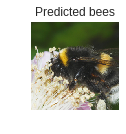

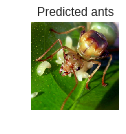

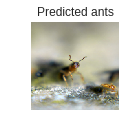

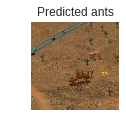

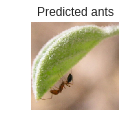

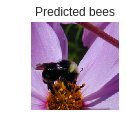

In [53]:
visualize_model(model_f)

### Convnet as a feature Extractor

Freezing the network except the final layer , need to set **requires_grad =False ** to freeze the params so that gradients are ot computed in backward pass 

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
# setting the gradient to false
for param in model_conv.parameters():
  param.requires_grad = False

# newly constructed layers have requires_grad=True by default
# fc is the fully connected layer at the end 
num_features = model_conv.fc.in_features
# replacing with a new layer with 512(num_features) input and 2 output
model_conv.fc = nn.Linear(num_features,2)

model_conv = model_conv.to(device)
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - SGD 
optimizer_conv = optim.SGD(model_conv.parameters(),lr=0.001,momentum=0.9)

# decaying learninng rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)


In [56]:
model_f

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

#### Training 

In [58]:
model_conv = train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
0 - train Loss: 0.790358908230164 Acc:0.6352459016393442
0 - val Loss: 0.24668203498802932 Acc:0.9019607843137255
Epoch 1/24
----------
1 - train Loss: 0.5042312217296147 Acc:0.7704918032786886
1 - val Loss: 0.37477882430444354 Acc:0.8366013071895425
Epoch 2/24
----------
2 - train Loss: 0.48546407335117214 Acc:0.7704918032786886
2 - val Loss: 0.15944075019531 Acc:0.934640522875817
Epoch 3/24
----------
3 - train Loss: 0.8535981256453717 Acc:0.6557377049180328
3 - val Loss: 0.20359106868310692 Acc:0.934640522875817
Epoch 4/24
----------
4 - train Loss: 0.4054288148391442 Acc:0.8155737704918034
4 - val Loss: 0.25128892551060594 Acc:0.9084967320261438
Epoch 5/24
----------
5 - train Loss: 0.4392685515225911 Acc:0.8073770491803279
5 - val Loss: 0.19031334780400094 Acc:0.9477124183006537
Epoch 6/24
----------
6 - train Loss: 0.4544559301900082 Acc:0.8155737704918034
6 - val Loss: 0.18011324117386263 Acc:0.9477124183006537
Epoch 7/24
----------
7 - train Loss: 0.386466

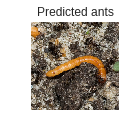

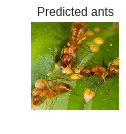

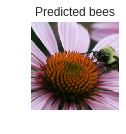

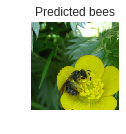

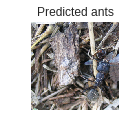

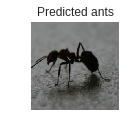

In [61]:
visualize_model(model_conv)
